In [2]:
!pip install tensorflow
!pip install tensorflow

In [3]:
!pip install tensorflow

In [1]:
import pandas as pd
import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import BertTokenizer
from transformers import TFBertModel # This will load the hugging face bert transformer and set it's parameters to tensorflow
# import tensorflow_hub as hub # to load the bert directly from tensorflow hub, already compatible with tensorflow environment.
import re
import os
import tensorflow_addons as tfa

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're usin

## Load Datasets

Use the datasets stored in gradient (paperspace) dataset

In [2]:
df = pd.read_csv('/datasets/imdb_dataset/imdb.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


##### Load data from google drive

In [3]:
print(df.groupby('sentiment').count())
print(df.head())

           review
sentiment        
negative    25000
positive    25000
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


#### Initialize the GPU in paperspace

In [4]:
gpu = tf.config.list_logical_devices('GPU')
with_gpu = None
if len(gpu) == 0:
    print('No GPU available')
else:
    print('GPU available')
    with_gpu = tf.device(gpu[0].name)
    print(gpu[0].name)

GPU available
/device:GPU:0


#### Setup GPU for google colab

In [8]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.experimental.TPUStrategy(resolver)

KeyError: 'COLAB_TPU_ADDR'

In [ ]:
print("Num TPUs Available: ", len(tf.config.list_logical_devices('TPU')))

Num TPUs Available:  8


### Preprocess the dataset

### Remove Unwanted characters, and try to use only the first 20000 rows of the data to speed up our fine-tunning.
- remove punctuation marks
- remove characters which are not letters or digits
- remove successive whitespaces
- convert the text to lower case
- strip whitespaces from the beginning and the end of the reviews

In [5]:
df.sentiment = [0 if s == 'negative' else 1 for s in df.sentiment]
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))

#### Plot the data distribution over the labels
- Determine how balance the dataset is.

In [6]:
print(df.sentiment.head())
print(df.shape)


0    1
1    1
2    1
3    0
4    1
Name: sentiment, dtype: int64
(50000, 2)


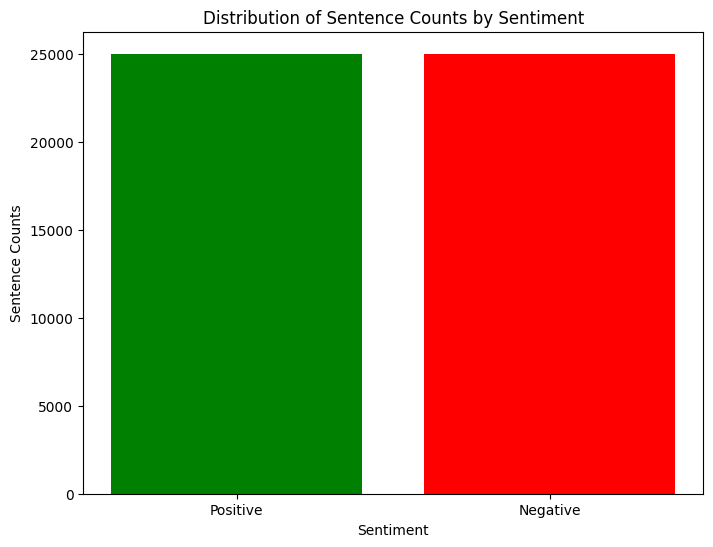

In [7]:
# Calculate the number of sentences for each sentiment category
positive_counts = len(df[df.sentiment == 1])
negative_counts = len(df[df.sentiment == 0])

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(['Positive', 'Negative'], [positive_counts, negative_counts], color=['green', 'red'])
plt.title('Distribution of Sentence Counts by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Sentence Counts')
plt.show()

#### Prepare data for Bert, padding them (masking them appropriately)
Let’s first see how the BERT tokenizer converts sentences into token ids. token ids : it is an integer that represents a particular token.

**attention mask** : it is a sequence of ones and zeroes to tell the model which token comes from input sentence (segment id =1) and which are just padding token(segment id =0).

**padding** : when we train BERT model we make sure that every input to the model should have same size that means same length of inputs so that the model can perform back propagation efficiently but all our input which are review text can not be in same size, some can be small review and some can be large. Padding is the technique where we make our entire review in the same size but first we have to decide a fixed length or max_length.

##### Split our dataset into 80/20
- Since these dataset is balanced and have enough dataset for splitting, it make sense that we can use 80/20

In [8]:
train, test = train_test_split(df, test_size=0.2)

train_sentences = train.review
train_labels = train.sentiment
test_sentences = test.review
test_labels = test.sentiment


print(train_sentences.shape, test_sentences.shape)
print(train_labels.shape, test_labels.shape)

(40000,) (10000,)
(40000,) (10000,)


#### Masking and Padding dataset
Hugging face library provides another function called tokenizer.encode_plus() which we will use to perform almost entire preprocessing steps in one go. It

converts reviews into tokens
adds [CLS] token at the beginning of input
performs padding if sequence length is less than max_len
performs truncation if sequence length is greater than max_len
adds [SEP] token at the end of sequence.

##### Use Colab GPU

##### Use Paperspace GPU

In [9]:
MAX_LEN = 128
EPOCCH = 20
BATCH_SIZE = 32
with with_gpu:
    print('Loading BERT tokenizer...')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


### Load the Model and set it up for Feature space transfers

##### Load model with paperspace GPU

In [10]:
with with_gpu:
    bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


##### Extract the Features and save them

In [ ]:
# Test saving to the paperspace file system
l = []
np.save('/notebooks/lab2/test.npy', np.array(l.extend(train_labels)))

In [11]:
def bytesto(bytes, to, bsize=1024):
    """convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytesto(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    for i in range(a[to]):
        r = r / bsize

    return(r)

def print_gpu_usage():
    print("GPU Peak Memory: ", bytesto(tf.config.experimental.get_memory_info('GPU:0')['peak'], 'g'), 'G')
    print("GPU Current Memory Usage: ", bytesto(tf.config.experimental.get_memory_usage('GPU:0'), 'g'), 'G')

##### Extract the features batch by batch to save the memory(paperspace memory issue resolution)

In [12]:
def save_bottleneck(bert_model, labels, tokenizer, ds, batch_size, max_length, filename_addendum, verbose=False):
    bottleneck_features = []
    labels_train = []

    batch_num = 1
    for i in range(0, ds.shape[0], batch_size):
        batch = ds.iloc[i:i+batch_size].tolist()
        label_batch = labels[i:i+batch_size]
        inputs = tokenizer(
            text=batch,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding=True,
            return_tensors='tf',
            return_token_type_ids=False,
            return_attention_mask=True,
            verbose=True
        )

        out = bert_model(inputs)
        bottleneck_features.extend(out.pooler_output)
        labels_train.extend(label_batch)

        del out
        if verbose and batch_num % 500 == 0:
            print("Batch {} - size {}".format(batch_num, len(batch)))
            print_gpu_usage()
        batch_num = batch_num + 1

    print("Total Number of batches {} - Length of bottleneck features {}".format(batch_num, len(bottleneck_features)))
    bottleneck_features = np.array(bottleneck_features)
    labels_train = np.array(labels_train)
    data_filename = '/notebooks/lab2/feature_space/bottleneck_features_{}_{}.npy'.format(filename_addendum, max_length)
    labels_filename = '/notebooks/lab2/feature_space/bottleneck_labels_{}_{}.npy'.format(filename_addendum, max_length)
    np.save(data_filename, bottleneck_features)
    np.save(labels_filename, labels_train)

    return data_filename, labels_filename

##### Extract the features via all at once if we have eough memory

In [16]:
type(train_sentences)

pandas.core.series.Series

In [13]:
train_ds, train_labels = save_bottleneck(bert_model, train_labels, tokenizer, train_sentences, BATCH_SIZE, MAX_LEN, 'train', True)
test_ds, test_labels = save_bottleneck(bert_model, test_labels, tokenizer, test_sentences, BATCH_SIZE, MAX_LEN, 'test', True)

/tmp/ipykernel_42/3310511887.py:8: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  label_batch = labels[i:i+batch_size]


Batch 500 - size 32
GPU Peak Memory:  0.7176620960235596 G
Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.
GPU Current Memory Usage:  0.46494030952453613 G
Batch 1000 - size 32
GPU Peak Memory:  0.7566635608673096 G
GPU Current Memory Usage:  0.5107166767120361 G
Total Number of batches 1251 - Length of bottleneck features 40000
Total Number of batches 314 - Length of bottleneck features 10000


### Train a classifier layer with extracted features
- Now we can train our classifier with the extracted features
- The classifier is simply a fully connected layer with 256 hidden units

In [14]:
from keras import backend as K


def fbeta_local(y_true, y_pred, beta=2.0):
    y_pred = K.clip(y_pred, 0, 1)
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # a
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1))) # d
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1))) 
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    
    percision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    num = (1 + (beta ** 2)) * percision * recall
    den =  ((beta ** 2) * percision) + recall + K.epsilon()
    return num / den

In [15]:
def get_top_model(input_shape, initial_learning_rate, decay_steps, decay_rate):
    """Creates a simple top model to be trained on top of the bottleneck features."""
    top_model = tf.keras.Sequential(name='imdb_classifier')
    top_model.add(layers.Dense(512, activation='relu', input_shape=(input_shape,)))
    top_model.add(layers.Dropout(0.5))
    top_model.add(layers.Dense(128, activation='relu'))
    top_model.add(layers.Dropout(0.5))
    top_model.add(layers.Dense(64, activation='relu'))
    top_model.add(layers.Dropout(0.2))
    top_model.add(layers.Dense(1, activation='sigmoid'))

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=False)  # You can set staircase=True for a staircase decay

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    top_model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=[
                        'accuracy',
                        # tfa.metrics.FBetaScore
                        # (
                        #   num_classes=1,
                        #   beta=2.0,
                        # )
                       fbeta_local 
                      ]
                    )
    return top_model

#### Train the top model

##### Load the foundational model saved feature space

In [16]:
with with_gpu:
  # Load bottleneck features that have already been extracted by base model
  saved_train_ds = np.load('/notebooks/lab2/feature_space/bottleneck_features_train_128.npy')
  # the first half of labels are sharks, and second half are dolphins
  saved_train_labels = np.load('/notebooks/lab2/feature_space/bottleneck_labels_train_128.npy')
  print('Training Data Shape: ',saved_train_ds.shape, 'Training Label Shape: ',saved_train_labels.shape)

  saved_test_ds = np.load('/notebooks/lab2/feature_space/bottleneck_features_test_128.npy')
  # the first half of labels are sharks, and second half are dolphins
  saved_test_labels = np.load('/notebooks/lab2/feature_space/bottleneck_labels_test_128.npy')
  print('Val Data Shape: ',saved_test_ds.shape, 'Val Label Shape: ', saved_test_labels.shape)



Training Data Shape:  (40000, 768) Training Label Shape:  (40000,)
Val Data Shape:  (10000, 768) Val Label Shape:  (10000,)


In [17]:
%%time

# Define the directory where you want to save the checkpoint file
checkpoint_dir = '/notebooks/lab2/checkpoint/'
# Create the directory if it doesn't exist
os.makedirs(checkpoint_dir, exist_ok=True)

# Define the directory where you want to save the top model weights and model itself
top_model_dir = '/notebooks/lab2/models/'
# Create the directory if it doesn't exist
os.makedirs(top_model_dir, exist_ok=True)

# Train model
with with_gpu:
    # setup params and where to save features
    epochs = EPOCCH
    batch_size = BATCH_SIZE

    initial_learning_rate = 0.001
    decay_steps = 1000
    decay_rate = 0.95
    top_model = get_top_model(saved_train_ds.shape[1], initial_learning_rate, decay_steps, decay_rate)

    print('Training top model, saving the checkpoint...')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'checkpoint_{epoch:02d}.h5'),
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

    print('Training transfer model from bottleneck...')
    history = top_model.fit(saved_train_ds, saved_train_labels,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[model_checkpoint_callback],
                            validation_data=(saved_test_ds, saved_test_labels),
                            verbose=1)

    print('Training complete.')

     # Save top model weights
    print('Saving top model weights...')
    top_model_weights_path = os.path.join(top_model_dir, 'top_model_weights.h5')
    top_model.save_weights(top_model_weights_path)

    # Save the entire top model
    print('Saving the top model...')
    top_model.save(os.path.join(top_model_dir, 'top_model.h5'))
    print('Done!')

Training top model, saving the checkpoint...
Training transfer model from bottleneck...
Epoch 1/20
1250/1250 [==============================] - 11s 8ms/step - loss: 0.6662 - accuracy: 0.5928 - fbeta_local: 0.5929 - val_loss: 0.5724 - val_accuracy: 0.7310 - val_fbeta_local: 0.7020
Epoch 2/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5947 - accuracy: 0.6872 - fbeta_local: 0.7212 - val_loss: 0.5192 - val_accuracy: 0.7501 - val_fbeta_local: 0.6947
Epoch 3/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5741 - accuracy: 0.7039 - fbeta_local: 0.7433 - val_loss: 0.5537 - val_accuracy: 0.7580 - val_fbeta_local: 0.7893
Epoch 4/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5622 - accuracy: 0.7096 - fbeta_local: 0.7495 - val_loss: 0.5242 - val_accuracy: 0.7706 - val_fbeta_local: 0.7745
Epoch 5/20
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5501 - accuracy: 0.7188 - fbeta_local: 0.7575 - val_loss: 0.5

#### Plot the result

In [18]:
def plot_training_validation_acc(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fbeta_score = history.history['val_fbeta_local']
    val_fbeta_score = history.history['val_fbeta_local']

    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)
        fbeta_score = smooth_curve(fbeta_score)
        val_fbeta_score = smooth_curve(val_fbeta_score)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.plot(epochs, fbeta_score, 'go', label='Training F-beta')
    plt.plot(epochs, val_fbeta_score, 'g', label='Validation F-beta')
    plt.title('Training and validation accuracy and F-beta score')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, val_fbeta_score, 'g', label='Validation F-beta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


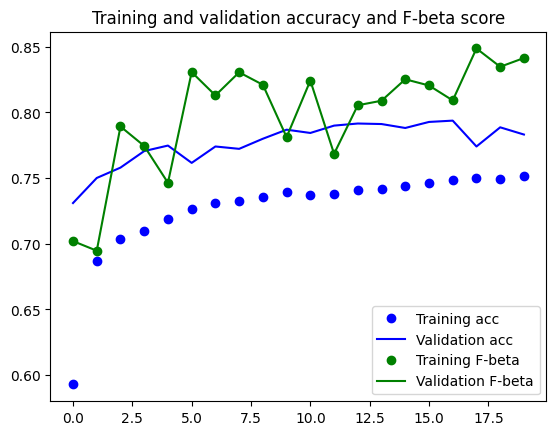

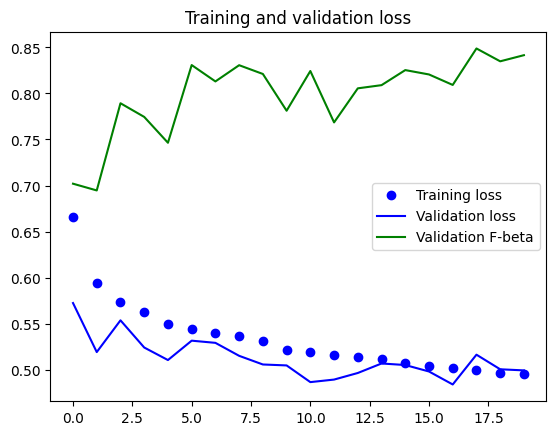

In [19]:
plot_training_validation_acc(history)

#### Fine-Tune the bert
- unfreeze 1 layer of bert and try to combine all the models together and train them, comparing it's performance with the old one.

In [20]:
%%time

def unfreeze_last_layer(model):
    """Unfreezes the last layer of a BERT model (classification head)."""
    for layer in model.layers:
        if layer.name == 'bert':
            print('Unfreezing the last layer of the BERT model...')
            print('Unfreezing last layer of ', len(layer.encoder.layer), ' layers')
            layer.trainable = False  # Set the entire BERT model as non-trainable
            layer.encoder.layer[-1].trainable = True  # Unfreeze the last layer
            layer.encoder.layer[-2].trainable = True  # Unfreeze the second to last layer
            print('Unfreezing last layer:', layer.encoder.layer[-1].name)
    return model

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 16.9 µs


In [21]:
# bert_model.summary()
# for layer in bert_model.layers:
#     print(layer.encoder.layer[-1].name)



with with_gpu:
    # Assuming bert_model is already defined and loaded
    model = unfreeze_last_layer(bert_model)

# Check if the last layer is trainable
    for layer in model.layers[0].encoder.layer:
        print(layer.name, layer.trainable)  
    # model.summary()


Unfreezing the last layer of the BERT model...
Unfreezing last layer of  12  layers
Unfreezing last layer: layer_._11
layer_._0 False
layer_._1 False
layer_._2 False
layer_._3 False
layer_._4 False
layer_._5 False
layer_._6 False
layer_._7 False
layer_._8 False
layer_._9 False
layer_._10 True
layer_._11 True


In [22]:
model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 0
Non-trainable params: 109,482,240
_________________________________________________________________


In [23]:
%%time

#
# Fine tune top bert 1st layer (classifier layer)
#
def combine_bert_top_model(bert_model, top_model):
    """Combines a BERT model with a top model."""
    with with_gpu:
        in_id = tf.keras.layers.Input(shape=(MAX_LEN,), name="input_ids", dtype='int32')
        in_mask = tf.keras.layers.Input(shape=(MAX_LEN,), name="input_masks",dtype='int32')

        base_model = unfreeze_last_layer(bert_model)
        
        # model = tf.keras.Model(inputs=[in_ids, in_masks], outputs=top_mode((bert_model[in_ids, in_mask])[1]))
        model = tf.keras.Model(
            inputs=[in_id, in_mask] , 
            outputs=top_model(base_model({'input_ids':in_id, 'attention_mask':in_mask})[1])
        )
    
        # compile the model with a SGD/momentum optimizer
        # and a very slow learning rate.
        model.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
                metrics=[
                    'accuracy',
                    tfa.metrics.FBetaScore
                    (
                        num_classes=1,
                        beta=2.0,
                    )  
            ]
        )
        return model

CPU times: user 10 µs, sys: 1 µs, total: 11 µs
Wall time: 17.2 µs


In [24]:
with with_gpu:
    combined_model = combine_bert_top_model(bert_model, top_model)
    combined_model.summary()

Unfreezing the last layer of the BERT model...
Unfreezing last layer of  12  layers
Unfreezing last layer: layer_._11
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_masks (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_masks[0][0]',            
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                        

In [25]:
def generate_tokens(text, tokenizer, max_len):
    """Generates tokens from a given text."""
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )
    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask']
    }

In [26]:
with with_gpu:
    train_tokens = generate_tokens(train_sentences.tolist(), tokenizer, MAX_LEN)
    test_tokens = generate_tokens(test_sentences.tolist(), tokenizer, MAX_LEN)


In [27]:
def train_combined_model(model, train_ds, test_ds, epochs=2):
    checkpoint_filepath = '/notebooks/lab2/checkpoints/'
    with with_gpu:
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)

        print('Fine tuning combined model...')
        history = model.fit(
            x={'input_ids': train_ds['input_ids'],'input_masks':train_ds['attention_mask']},
            y = train['sentiment'], 
            epochs=epochs,
            batch_size=BATCH_SIZE,
            callbacks=[model_checkpoint_callback],
            validation_data = (
                {'input_ids':test_ds['input_ids'], 'input_masks':test_ds['attention_mask']},
                test['sentiment']
            ),
            verbose=True
        )
        return history

#### Train the combined model

In [30]:
%%time

with with_gpu:
    history = train_combined_model(combined_model, train_tokens, test_tokens, 3)

Fine tuning combined model...
Epoch 1/3
  21/1250 [..............................] - ETA: 6:09 - loss: 0.5118 - accuracy: 0.7307 - fbeta_score: 0.8300

KeyboardInterrupt: 

#### Plot the result of the fine tuned model.

In [ ]:
def plot_combined_model(history, smooth=False, smooth_factor=0.8):
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fbeta_score = history.history['fbeta_score']
    val_fbeta_score = history.history['val_fbeta_score']

    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)
        loss = smooth_curve(loss)
        val_loss = smooth_curve(val_loss)
        fbeta_score = smooth_curve(fbeta_score)
        val_fbeta_score = smooth_curve(val_fbeta_score)

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.plot(epochs, fbeta_score, 'go', label='Training F-beta')
    plt.plot(epochs, val_fbeta_score, 'g', label='Validation F-beta')
    plt.title('Training and validation accuracy and F-beta score')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, val_fbeta_score, 'g', label='Validation F-beta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


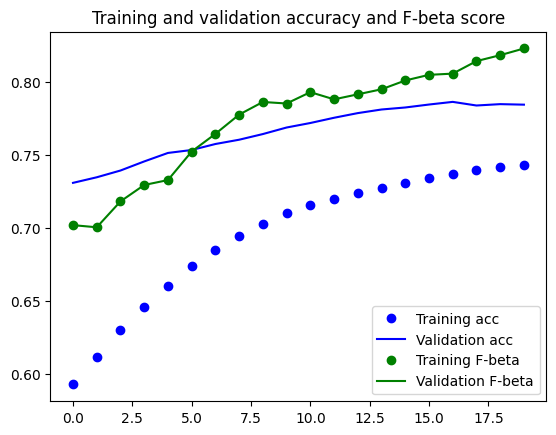

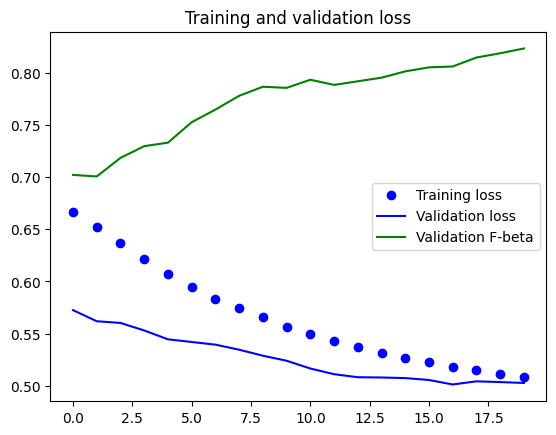

In [29]:
plot_training_validation_acc(history, smooth=True)